In [185]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
import scipy.optimize as opt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import svm # the classifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, classification_report,ConfusionMatrixDisplay # for model evaluation
import matplotlib.pyplot as plt
from sklearn import datasets
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [186]:
digits = datasets.load_digits()

In [187]:
min(digits.target), max(digits.target)

(0, 9)

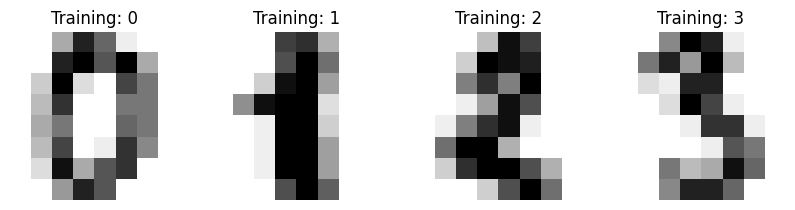

In [188]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [189]:
import time
import dill
import os 
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import KAN_NN_fast_repeat
import KAN_NN_fast
import importlib
importlib.reload(KAN_NN_fast_repeat)
importlib.reload(KAN_NN_fast)



<module 'KAN_NN_fast' from 'c:\\Users\\JP\\Documents\\TU Berlin\\Master\\Code_clean\\AAAA\\KAN_NN_fast.py'>

In [190]:
import torch
y = torch.tensor(digits.target).long()
y_one_hot = torch.nn.functional.one_hot(y, num_classes=10)
print(y_one_hot.shape)

torch.Size([1797, 10])


In [191]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
def get_loader():
    # Set the seed for reproducibility
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    digits = datasets.load_digits()
    print(digits.keys())

    # Generate the Friedman dataset
    X = torch.tensor(digits.data, dtype=torch.float32)
    y = torch.tensor(digits.target).long()
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=10).unsqueeze(-1)

    X_train, X_test, y_train, y_test = train_test_split(X,y_one_hot, test_size = 0.2, random_state=365, stratify=y)

    # Apply feature scaling (Standardization) ONLY to `X`
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)  # Fit and transform training data
    X_test = scaler_X.transform(X_test)        # Transform test data (using train stats)

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = y_train.clone().detach().float()  # Keep `y` unchanged
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = y_test.clone().detach().float()    # Keep `y` unchanged

    # Create TensorDataset for train and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Set batch size and create DataLoader for training and testing
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    return train_loader, test_loader

In [192]:
import torch.nn as nn
class Neural_Kan(nn.Module):
    """
    Class:
    shape: list, describing tuple (n_1,...,n_N)
    h: shape of univariate Neural Networks. 
    """
    def __init__(self, shape, h, device = None):
        super(Neural_Kan, self).__init__()
        self.train_loss = []
        self.test_loss = []
        self.layers = nn.Sequential()
        self.softmax = nn.Identity()#nn.Softmax(dim=1)
        for i in range(len(shape) - 1):
            self.layers.append(KAN_NN_fast.KAN_layer(in_dim = shape[i], out_dim = shape[i + 1], hidden = h))

    def forward(self,x):
        if x.shape[0] == 1:
            out = self.layers(x)
            return self.softmax(out).squeeze().unsqueeze(-1).unsqueeze(0)
        out = self.layers(x).squeeze()
        return self.softmax(out).unsqueeze(-1)
        


In [193]:
shape = [64, 128,128, 10]
model = Neural_Kan(shape = shape, h = [16])
input = torch.tensor(digits.data[:1], dtype=torch.float32)#.unsqueeze(-1)
print(input.shape)
print(model(input))



torch.Size([1, 64])
tensor([[[-0.0064],
         [ 0.0083],
         [-0.0138],
         [ 0.0123],
         [-0.0078],
         [-0.0188],
         [ 0.0091],
         [ 0.0043],
         [ 0.0180],
         [-0.0136]]], grad_fn=<UnsqueezeBackward0>)


In [ ]:
@torch.no_grad()
def compute_test_loss(test_loader, model):
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.
    for batch, target in test_loader:
        outputs = model(batch)
        loss = criterion(target, outputs)
        running_loss += loss.item()
    return running_loss / len(test_loader)

In [195]:
train_loader, test_loader = get_loader()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


Neural_Kan(
  (layers): Sequential(
    (0): KAN_layer(
      (layers): Sequential(
        (0): Input_Linear()
        (1): Output_Linear()
      )
    )
    (1): KAN_layer(
      (layers): Sequential(
        (0): Input_Linear()
        (1): Output_Linear()
      )
    )
    (2): KAN_layer(
      (layers): Sequential(
        (0): Input_Linear()
        (1): Output_Linear()
      )
    )
  )
  (softmax): Identity()
)
tensor([[ 0.1307],
        [-0.1685],
        [-0.2833],
        [-0.3374],
        [ 0.4080],
        [ 0.2431],
        [-0.0380],
        [ 0.0664],
        [-0.2810],
        [-0.0207]], grad_fn=<SliceBackward0>) tensor([4])
Epoch [1/200], Loss: 2.294257, test: 0.749144, lr: 0.001000, time = 4.233081817626953
tensor([[ 3.1144],
        [-2.6183],
        [-2.9399],
        [-2.6213],
        [ 2.7013],
        [ 2.4563],
        [ 0.2212],
        [ 1.1327],
        [-2.2008],
        [-0.1050]], grad_fn=<SliceBackward0>) tensor([5])
Epoch [2/200], Loss: 1.916488, te

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [200/200], Loss: 0.000026, test: -5.453604, lr: 0.001000, time = 4.246001720428467


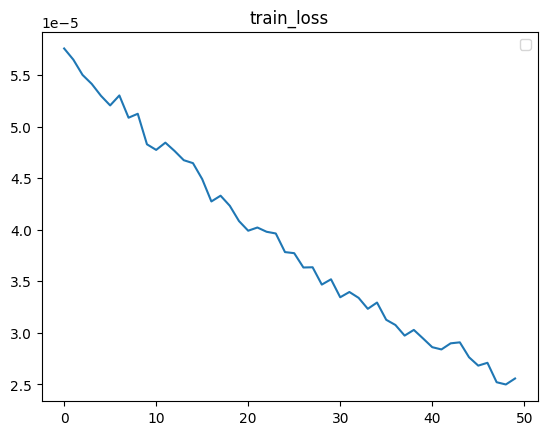

Training Complete!


In [196]:
import torch.optim as optim
epochs = 200
train_losses = []
test_losses = []
model.train()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print(model)
for epoch in range(epochs):
    running_loss = 0.0
    start_time = time.time()
    for count, (batch, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(batch)
        targets = target.argmax(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(outputs[1,:], targets[1,:])
    end_time = time.time()
    avg_loss = running_loss / len(train_loader)
    model.train_loss.append(avg_loss)
    test_l = compute_test_loss(test_loader, model)
    model.test_loss.append(test_l)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.6f}, test: {test_l:.6f}, lr: {optimizer.param_groups[0]['lr']:6f}, time = {end_time - start_time}")
plt.plot(model.train_loss[-50:])
plt.title(f'train_loss')
plt.legend()
plt.show()
print("Training Complete!")



In [203]:
def Xy_test():
    # Set the seed for reproducibility
    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)
    digits = datasets.load_digits()
    print(digits.keys())

    # Generate the Friedman dataset
    X = torch.tensor(digits.data, dtype=torch.float32)
    y = torch.tensor(digits.target)
    #y_one_hot = torch.nn.functional.one_hot(y, num_classes=10).unsqueeze(-1)

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=365, stratify=y)

    # Apply feature scaling (Standardization) ONLY to `X`
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)  # Fit and transform training data
    X_test = scaler_X.transform(X_test)        # Transform test data (using train stats)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor  = y_test.clone().detach().float()    # Keep `y` unchanged
    return X_test_tensor, y_test_tensor
X_test, y_test = Xy_test()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [198]:
X_test.shape

torch.Size([360, 64])

In [207]:
predicition = model(X_test).squeeze()

In [211]:
softmax = nn.Softmax(dim = 1)
predicition = softmax(predicition)

In [212]:
predicition

tensor([[5.0183e-20, 2.7963e-20, 1.3923e-38,  ..., 0.0000e+00, 4.9127e-23,
         6.3669e-33],
        [1.0000e+00, 3.9338e-28, 7.3057e-40,  ..., 7.3869e-28, 2.8049e-28,
         5.9734e-21],
        [4.9630e-15, 4.4287e-05, 4.1439e-11,  ..., 9.8533e-01, 3.0062e-06,
         7.4796e-10],
        ...,
        [7.2517e-14, 4.7388e-20, 2.1894e-16,  ..., 9.9882e-01, 1.1464e-29,
         9.8748e-12],
        [0.0000e+00, 6.1657e-44, 1.0000e+00,  ..., 0.0000e+00, 3.7460e-25,
         4.4935e-41],
        [8.8427e-27, 3.1061e-36, 8.0269e-33,  ..., 0.0000e+00, 4.9509e-15,
         1.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [216]:
yhat = torch.argmax(predicition, dim = 1)
print(yhat.shape)
yhat[0:5]

torch.Size([360])


tensor([6, 0, 7, 9, 0])

In [217]:
y_test[:5]

tensor([6., 0., 7., 4., 0.])

Avg F1-score: 0.9527
Accuracy: 0.9528
Precision: 0.9528
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      0.95      0.93        37
           2       0.97      0.94      0.96        35
           3       0.97      0.92      0.94        37
           4       0.97      0.92      0.94        36
           5       0.97      1.00      0.99        36
           6       0.97      1.00      0.99        36
           7       0.90      1.00      0.95        36
           8       0.91      0.91      0.91        35
           9       0.94      0.92      0.93        36

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360



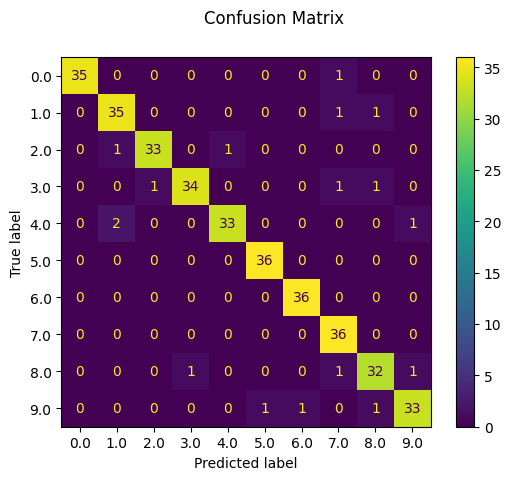

Confusion matrix:
[[35  0  0  0  0  0  0  1  0  0]
 [ 0 35  0  0  0  0  0  1  1  0]
 [ 0  1 33  0  1  0  0  0  0  0]
 [ 0  0  1 34  0  0  0  1  1  0]
 [ 0  2  0  0 33  0  0  0  0  1]
 [ 0  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  1  0  0  0  1 32  1]
 [ 0  0  0  0  0  1  1  0  1 33]]


In [218]:
f1 = f1_score(y_test, yhat, average='weighted')
accuracy = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average='micro')

print("Avg F1-score: %.4f" % f1)
print("Accuracy: %.4f" % accuracy)
print("Precision: %.4f" % precision)

from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(y_test, yhat,labels=np.unique(yhat)))
disp = ConfusionMatrixDisplay.from_predictions(y_test, yhat)
disp.figure_.suptitle("Confusion Matrix")

plt.show()


print(f"Confusion matrix:\n{disp.confusion_matrix}")